# Neural & Behavioral Modeling - Week 3 (Exercises)
by 李彥廷 (b08207008@ntu.edu.tw)

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
from numpy import *
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
from IPython.display import *
import scipy.stats as stats
from itertools import *
from sklearn.preprocessing import scale


## Replicate exisiting findings/models (10 points)
Based on your personal interest, please choose and replicate ONE of the following studies:

1. <a href="http://ccl.northwestern.edu/netlogo/models/FlockingVeeFormations">Flocking Vee Formations</a> in NetLogo's [Sample Models::Biology] 

2. <a href="http://ccl.northwestern.edu/netlogo/models/WolfSheepPredation">Wolf-Sheep Predation</a> in NetLogo's [Sample Models::Biology] 

3. <a href="https://kknews.cc/zh-tw/news/p56pbrp.html">MIT Matching Game</a>

4. Gray, K., Rand, D. G., Ert, E., Lewis, K., Hershman, S., & Norton, M. I. (2014). <a href="http://www.mpmlab.org/groups/">The emergence of “us and them” in 80 lines of code: Modeling group genesis in homogeneous populations</a>. Psychological Science, 25(4), 982-990.

5. Luhmann, C. C., & Rajaram, S. (2015). <a href="http://journals.sagepub.com/doi/abs/10.1177/0956797615605798">Memory transmission in small groups and large networks: An agent-based model</a>. Psychological Science, 26(12), 1909-1917.

6. Henriques, G. J., Simon, B., Ispolatov, Y., & Doebeli, M. (2019). <a href="https://www.pnas.org/content/116/28/14089">Acculturation drives the evolution of intergroup conflict</a>. Proceedings of the National Academy of Sciences, 116(28), 14089-14097.

In [2]:
# Write your codes here
class Person:
    '''
    A person endowed with the ability to encode and retrieve stimuli.
    '''
    def __init__(self, alpha, beta, gamma, itemList, A, S): 
        '''
        Specifies three parameters and itemList to study.
        A and S are activation vector and inter-item associations w.r.t to itemList.
        A must be a list or array with same length as that of itemList.
        S must be a 2d-array or matrix with the number of rows and columns is same as the length of itemList.
        if A and S are not given, they will be randomly generated.
        '''
        self.alpha=alpha
        self.beta=beta
        self.gamma=gamma
        self.itemList=array(itemList)
        self.iniA = array(A)
        NitemList = len(self.itemList)
        self.A = self.iniA/self.iniA.sum(axis=0)
        self.S = array(S)
        fill_diagonal(self.S, 1) # Self association = 1
        
    def encode(self, item): 
        '''
        Encode the "item" and update Activation vector according to 
        inter-item associations
        '''
        [item_index], = where(self.itemList == item)
        A_item = self.A[item_index]
        
        # Update Activation vector
        if A_item != self.A.max(): # not the maximum activated item
            A_max = self.A.max()
            [A_max_index], = where(self.A == A_max)
            S_max_j = self.S[A_max_index]
            self.A = self.A - self.beta*S_max_j*self.A # combine eq1 and eq2 by filling S_diag with 1
        
        self.A[item_index] = A_item + self.alpha*(1-A_item) # eq3
        self.A = self.A/self.A.sum(axis=0) # normalize activation vector
            
    def retrieve(self, retrivedItemList):
        '''
        #1 Determine whether the retrieving process is successful.
        #2 If true, retrive an item from itemList according to probability from activation vector.
        #3 The retrieving process will fail if the retrieved item was previously retrieved.
        '''
        success_retrieve = bool(random.binomial(1,self.gamma)) #1 success_retrieve or not
        #2 if success, pick one item from itemList according to prob. from activation vector
        if success_retrieve:
            self.A = self.A/self.A.sum(axis=0) # normalize again to prevent float-point error
            retrieved_item = random.choice(self.itemList, p=self.A)
            
            #3 Fail to recall if the item was previously retrieved
            if retrieved_item not in retrivedItemList: 
                [retrieve_item_idx], = where(self.itemList == retrieved_item)

                S_item_j = self.S[retrieve_item_idx].copy()
                S_item_j[retrieve_item_idx] = 0 # prevent modification of A_i from changing S_ii to 0
                self.A = self.A + self.beta*S_item_j*self.A # eq4
                
                return retrieved_item

In [3]:
class CMT:
    '''
    Collaborative Memory Task
    '''
    def __init__(self, NRound, itemList=arange(1, 41)):
        '''
        Specified the number of Round and studying stimuli in a Collaborative Memory Task.
        '''
        self.NRound = NRound
        self.itemList = itemList
        self.SubjectList = []
        self.col_retrievedItemList = []
        self.iso_retrievedItemList = []
        self.col_result=None
        self.iso_result=None
        
    def AddParticipants(self, alpha, beta, gamma, N, Alist, Slist):
        '''
        Add a number of participants with given parameters.
        '''
        for i in range(N):
            A=Alist[i]
            S=Slist[i]
            self.SubjectList.append(Person(alpha, beta, gamma, self.itemList, A, S)) # study solely
            
    def RunColRounds(self):
        '''
        #1 During each round, each agent was given an opportunity to retrieve an item.
        #2 The order in which the agents executed the retrieval was determined randomly in each round.
        #3 If an agent successfully retrieved an item, it was encoded by the other two agents.
        #4 If an agent attempted to retrieve a previously retrieved item, this retrieval failed.
        '''
        self.col_retrievedItemList.clear()
        for i in range(self.NRound): 
            random.shuffle(self.SubjectList) #2
            for sub in self.SubjectList: #1
                r_item = sub.retrieve(self.col_retrievedItemList) #4
                if r_item is not None:
                    self.col_retrievedItemList.append(r_item)
                    for sub in self.SubjectList: #3
                    # encode the retrieved item
                        sub.encode(r_item)
        self.col_result = len(self.col_retrievedItemList)
        
    def get_ColResults(self):
        return self.col_retrievedItemList, self.col_result
    
    def RunIsoRounds(self):
        '''
        In a nominal group, each participants recall words individually.
        The performance is calculated as nonredundant recall of all participants in the group.
        '''
        self.Seperate_rlist = [[] for i in self.SubjectList]
        for r in range(self.NRound):
            for i in range(len(self.SubjectList)):
                sub = self.SubjectList[i]
                rlist = self.Seperate_rlist[i]
                r_item = sub.retrieve(rlist)
                if r_item is not None:
                    rlist.append(r_item)
                    sub.encode(r_item)
        self.iso_retrievedItemList = list(set.union(*map(set, self.Seperate_rlist)))
        self.iso_result = len(self.iso_retrievedItemList)
        
    def get_IsoResults(self):
        return self.iso_retrievedItemList, self.iso_result
    
    def get_Similarity(self):
        CList = list(combinations(self.SubjectList,2)) # C(3,2) of participants
        ACList = [(sub[0].A, sub[1].A) for sub in CList]
        pearsonrList = [stats.pearsonr(*pair)[0] for pair in ACList]
        self.Sim = mean(pearsonrList)
        return self.Sim      

## Functions

In [4]:
# 3 random activation vector for collaborative CGroup and nominal CGroups

P_Col_list = []
P_Nom_list = []
PreColab_Similarity_list = []
PreNomin_Similarity_list = []
PostColab_Similarity_list = []
PostNomin_Similarity_list = []

def Simulation(NSim):
    for s in range(NSim):
#         random.seed=s
        # ======= Common Parameters =======
        NRound=20
        NItem=40
        Npeople=3
        alpha, beta, gamma = 0.2, 0.05, 0.75
        randomAlist=[random.uniform(0,1,size=NItem) for i in range(Npeople)]
        randomSlist=[]
        for i in range(Npeople):
            temp = random.uniform(-.2,.2,size=(NItem,NItem))
            S = (temp + temp.T)/2
            fill_diagonal(S,1)
            randomSlist.append(S)

        CGroup = CMT(NRound=NRound, itemList=arange(NItem))
        NGroup = CMT(NRound=NRound, itemList=arange(NItem))

        # ======= Nominal Group =======
        NGroup.AddParticipants(alpha, beta, gamma, N=Npeople, Alist=randomAlist, Slist=randomSlist)
        PreNomin_Similarity_list.append(NGroup.get_Similarity())
        NGroup.RunIsoRounds()
        PostNomin_Similarity_list.append(NGroup.get_Similarity())
        RList_NG, P_NG = NGroup.get_IsoResults()
        P_Nom_list.append(P_NG)
        
        # ======= Colaborative Group =======
        CGroup.AddParticipants(alpha, beta, gamma, N=Npeople, Alist=randomAlist, Slist=randomSlist)
        PreColab_Similarity_list.append(CGroup.get_Similarity())
        CGroup.RunColRounds()
        PostColab_Similarity_list.append(CGroup.get_Similarity())
        RList_CG, P_CG = CGroup.get_ColResults()
        P_Col_list.append(P_CG)

def pairedTtest(x1, x2):
    x1 = array(x1)
    x2 = array(x2)
    x1_bar = x1.mean()
    x2_bar = x2.mean()
    Tstat, pvalue = stats.ttest_rel(x1, x2)
    df = len(x1)-1
    stdev = std(x1 - x2)
    CohenD = (x1_bar-x2_bar)/stdev
    print("Paired Sample t test:")
    print(f't({df})={round(Tstat,4)}', ',' , f"p<{pvalue}")
    print('Cohen\'s d =', CohenD)

def jitter(ax):
    dots = ax.collections[-1]
    offsets = dots.get_offsets()
    jittered_offsets = offsets + random.uniform(0, 0.025, offsets.shape)
    dots.set_offsets(jittered_offsets)
    
def regline(ax, x, y):
    m, b = polyfit(x, y, 1)
    ax.plot(x, m*x+b, color='black')
    r, p = stats.pearsonr(x,y)
    return r, p

def plotRelation(PreColab_Similarity_list, P_Nom_list, P_Col_list, NItem):
    x = scale(PreColab_Similarity_list)
    y_n = array(P_Nom_list)/NItem
    y_c = array(P_Col_list)/NItem
    y = [y_n,y_c]
    yname = ['Nominal Group','Collaborative Group']

    fig, axes = plt.subplots(1,2, figsize = (12,5))
    for i in range(2):
        axes[i].scatter(x, y[i], marker='o', linewidth=1, alpha=.2, color='#990000')
        axes[i].set_xlim([-4,4])
        axes[i].set_ylim([y[i].min()-0.1, y[i].max()+0.1])
        axes[i].set_xlabel('Precollaboration Similarity')
        axes[i].set_ylabel(yname[i]+' Recall')
        r, p = regline(axes[i], x, y[i])
        print(f'{yname[i]}: r={r}, p={p}')
        jitter(axes[i])

## Simulation
Simulated 3,000 separate pairs of groups (i.e., 3,000 collaborative groups and 3,000 nominal groups) and compare the percentage of words recalled in the studying list between collaborative groups and nominal groups.  
The parameter of all agents were alpha = .2, beta = .05, gamma = .75.  
The agents in collaborative groups is identical to the agents in nominal groups. These contain the same sets of activation vectors so that the differences between two groups only result from the task design.


In [5]:
Simulation(3000)

### Relation between "Precolaboration Similarity" and "Performance"


Nominal Group: r=-0.059249664879330526, p=0.0011673588274663728
Collaborative Group: r=-0.0029623415536096306, p=0.8711587021381145


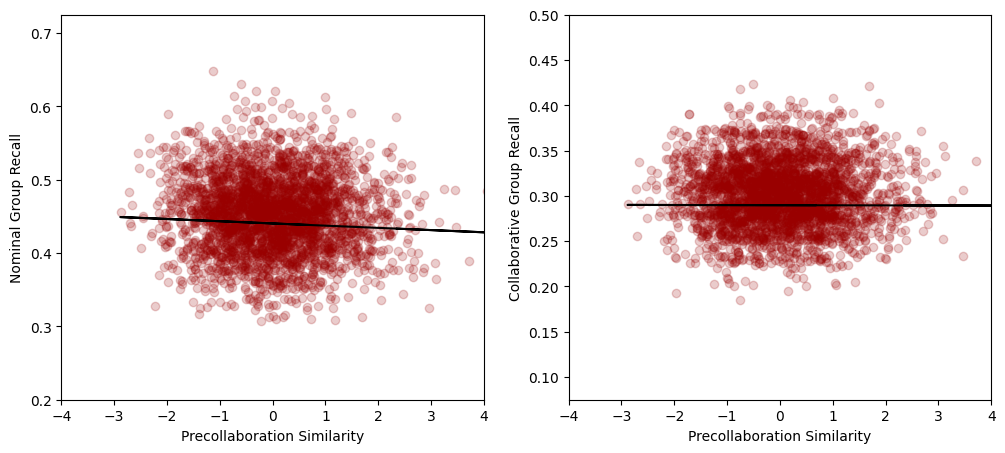

In [6]:
print()
plotRelation(PreColab_Similarity_list, P_Nom_list, P_Col_list, NItem=40)

### t-test of the number of recall items

In [7]:
print('Mean # of items recalled in Nominal Group:', mean(P_Nom_list), sep='\n')
print()
print('Mean # of items recalled in Collaborative Group:', mean(P_Col_list), sep='\n')
print()
pairedTtest(P_Nom_list, P_Col_list)

Mean # of items recalled in Nominal Group:
17.615333333333332

Mean # of items recalled in Collaborative Group:
11.589666666666666

Paired Sample t test:
t(2999)=132.994 , p<0.0
Cohen's d = 2.428531616107229


### Similarity Difference After Task

#### Similarity Difference of Collaborative Group Before and After Task

In [8]:
print('Pre-Task Similarity of Collaborative Group:', mean(PreColab_Similarity_list), sep='\n')
print()
print('Post-Task Similarity of Collaborative Group:', mean(PostColab_Similarity_list), sep='\n')
print()
pairedTtest(PostColab_Similarity_list, PreColab_Similarity_list)

Pre-Task Similarity of Collaborative Group:
-0.0010302316586687911

Post-Task Similarity of Collaborative Group:
0.9978309976684407

Paired Sample t test:
t(2999)=592.717 , p<0.0
Cohen's d = 10.823287297742674


#### Similarity Difference of Nominal Group Before and After Task

In [9]:
print('Pre-Task Similarity of Nominal Group:', mean(PreNomin_Similarity_list), sep='\n')
print()
print('Post-Task Similarity of  Nominal Group:', mean(PostNomin_Similarity_list), sep='\n')
print()
pairedTtest(PostNomin_Similarity_list, PreNomin_Similarity_list)

Pre-Task Similarity of Nominal Group:
-0.0010302316586687911

Post-Task Similarity of  Nominal Group:
-0.0008133620051050044

Paired Sample t test:
t(2999)=0.0969 , p<0.9228498034493672
Cohen's d = 0.001768575997932661


## Group Size

In [10]:
GroupSize = [1, 2, 3, 4, 5, 6, 7, 8, 10 ,16, 32, 64, 128]
# df = pd.DataFrame(columns=['GroupSize','ColGroup','NomGroup','Inhibition'])
dataList=[]

for Gsize in GroupSize:
    Col_list = []
    Nom_list = []
    for s in range(1000):
        # ======= Common Parameters =======
        NRound=20
        NItem=40
        Npeople=Gsize
        alpha, beta, gamma = 0.2, 0.05, 0.75
        randomAlist = [random.uniform(0,1,size=NItem) for i in range(Gsize)]
        randomSlist=[random.uniform(-.2, .2,size=(NItem,NItem)) for i in range(Gsize)]
    
        CGroup = CMT(NRound=NRound, itemList=arange(NItem))
        NGroup = CMT(NRound=NRound, itemList=arange(NItem))

        # ======= Colaborative Group =======
        CGroup.AddParticipants(alpha, beta, gamma, N=Gsize, Alist=randomAlist, Slist=randomSlist)
        CGroup.RunColRounds()
        RList_CG, P_CG = CGroup.get_ColResults()
        P_CG = P_CG/NItem
        Col_list.append(P_CG)

        # ======= Nominal Group =======
        NGroup.AddParticipants(alpha, beta, gamma, N=Gsize, Alist=randomAlist, Slist=randomSlist)
        NGroup.RunIsoRounds()
        RList_NG, P_NG = NGroup.get_IsoResults()
        P_NG = P_NG/NItem
        Nom_list.append(P_NG)

    dataList.append({'GroupSize':Gsize,
                     'ColGroup':mean(Col_list),
                     'NomGroup':mean(Nom_list),
                     'Inhibition':mean(Nom_list)-mean(Col_list)})
    
df = pd.DataFrame.from_records(dataList)
    
    
#     thisGroup = pd.DataFrame([{'GroupSize':Gsize,
#                                'ColGroup':mean(Col_list),
#                                'NomGroup':mean(Nom_list),
#                                'Inhibition':mean(Nom_list)-mean(Col_list)}])
    


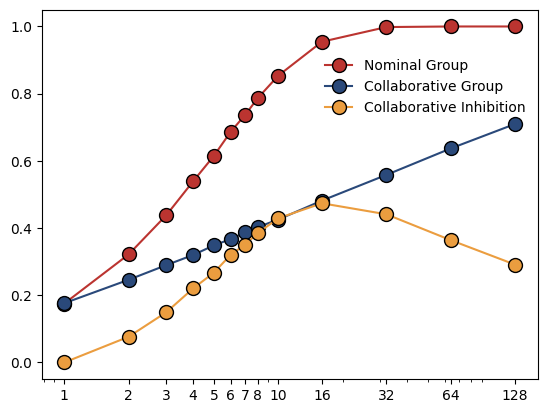

In [11]:
dct=dict(marker='o',ms=10,mew=1,mec='black')
plt.plot(df.GroupSize, df.NomGroup, color='#BB3430', **dct); # true answer
plt.plot(df.GroupSize, df.ColGroup, color='#2A497A', **dct) # approximation
plt.plot(df.GroupSize, df.Inhibition, color='#EB9D3F', **dct) # approximation
plt.legend(['Nominal Group','Collaborative Group','Collaborative Inhibition']
           , loc=1, bbox_to_anchor=(1, 0.9), frameon=False)
plt.xscale('log')
ax1 = plt.gca()
ax1.set_xticks(GroupSize)
ax1.set_yticks(linspace(0,1,6))
ax1.get_xaxis().set_major_formatter(ticker.ScalarFormatter())